In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from scipy.stats import binom

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42
mono_color = "orchid"
poly_color = "green"

In [2]:
save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

# directory where the simulation data and table with clonal counts and polyclonal calls are saved
# defaults to path in repo relative to current WD
output_dir = "../../data/clonal_count_estimation/"

In [3]:
PUTH_clonal = pd.read_csv(output_dir+"PUTH_clonal_SNVs.csv", index_col=0)
SCORT_clonal = pd.read_csv(output_dir+"SCORT_clonal_SNVs.csv", index_col=0)

In [4]:
maf_dir = ""

# SPECIFY LOCATION OF MAF FILES FOR THE TWO EXTERNAL COHORTS (NOT PROVIDED)
Li_FAP_WES_loc = maf_dir+"PUTH_filtered_ppVAFs.maf"
PUTH_maf = pd.read_csv(Li_FAP_WES_loc, sep="\t")

Cross_sporadic_WES_loc = maf_dir+"SCORT_filtered_ppVAFs.maf"
SCORT_maf = pd.read_csv(Cross_sporadic_WES_loc, sep="\t")

In [5]:
PUTH_clonal["lesion"] = ["_".join(x.split("_")[1:3]) for x in PUTH_clonal.index]
PUTH_sample_to_lesion = dict(zip(PUTH_clonal.index, PUTH_clonal["lesion"]))
PUTH_maf["lesion"] = [PUTH_sample_to_lesion[x] for x in PUTH_maf["Tumor_Sample_Barcode"]]
PUTH_clonal.sort_values("lesion", inplace=True)

In [6]:
PUTH_snvs = PUTH_maf[PUTH_maf["Variant_Type"]=="SNP"]

mut_counts = PUTH_snvs.value_counts("Tumor_Sample_Barcode")
sample_to_total = dict(zip(mut_counts.index, mut_counts.values))

PUTH_clonal["total_counts"] = [sample_to_total[x] for x in PUTH_clonal.index]

In [7]:
WGS_cutoff = 27 + 36
WES_cutoff = WGS_cutoff * 0.02

def number_shared_MRS(lesion_maf):
    shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
    return np.sum(shared_muts==len(set(lesion_maf["Tumor_Sample_Barcode"])))

multiregion_lesions = pd.value_counts(PUTH_clonal["lesion"])
multiregion_lesions = multiregion_lesions[multiregion_lesions > 1]
#multiregion_lesions = multiregion_lesions[~np.isin([x.split("_")[0] for x in multiregion_lesions.index], to_exclude)]
shared_counts_MRS = []
for lesion in multiregion_lesions.index:
    only_lesion = PUTH_snvs[PUTH_snvs["lesion"]==lesion]
    shared_counts_MRS.append(number_shared_MRS(only_lesion))

/share/software/user/open/py-seaborn/0.12.1_py39/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/share/software/user/open/py-seaborn/0.12.1_py39/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


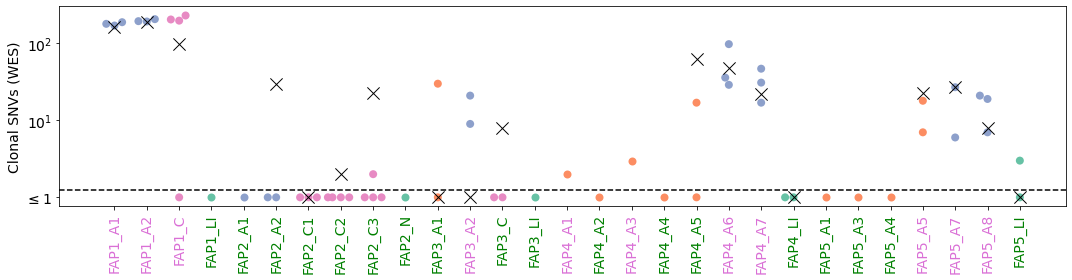

In [8]:
# EXTENDED DATA FIGURE 8a

counted_labels = PUTH_clonal.groupby("lesion").min()
counted_labels = dict(zip(counted_labels.index, counted_labels["stage"]))

counted = PUTH_clonal.groupby("lesion").mean()
counted["is_poly"] = counted["is_poly"] >= 0.5
counted["stage"] = [counted_labels[x] for x in counted.index] 

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.swarmplot(x=PUTH_clonal["lesion"], y=np.log10(np.maximum(1, PUTH_clonal["final_clonal"])), hue=PUTH_clonal["stage"], hue_order=["Mucosa", "Benign", "Dysplasia", "AdCa"], palette="Set2", legend=None, ax=ax, size=8)
sns.scatterplot(x=multiregion_lesions.index, y=np.log10(np.maximum(shared_counts_MRS, 1)), marker="x", s=150, color="k", zorder=100)
ax.axhline(y=np.log10(WES_cutoff), color="k", linestyle="dashed")
plt.xticks(rotation=90, fontsize=14)

for xtick in ax.get_xticklabels():
    if counted.loc[xtick._text]["is_poly"]:
        xtick.set_color(poly_color)
    else:
        xtick.set_color(mono_color)

plt.yticks(ticks = [0, 1, 2], labels = ["$\leq 1$", "$10^{1}$", "$10^{2}$"], fontsize=14)
plt.ylabel("Clonal SNVs (WES)", fontsize=14)
#plt.yscale("log")
plt.xlabel("")
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8a_FAP_Li_clonalmuts.pdf")
plt.show()

In [9]:
SCORT_snvs = SCORT_maf[SCORT_maf["Variant_Type"]=="SNP"]

mut_counts =SCORT_snvs.value_counts("Tumor_Sample_Barcode")
sample_to_total = dict(zip(mut_counts.index, mut_counts.values))

SCORT_clonal["total_counts"] = [sample_to_total[x] for x in SCORT_clonal.index]


In [10]:
multiregion_lesions = pd.value_counts(SCORT_clonal["patient"])
multiregion_lesions = multiregion_lesions[multiregion_lesions > 1]
#multiregion_lesions = multiregion_lesions[~np.isin([x.split("_")[0] for x in multiregion_lesions.index], to_exclude)]
shared_counts_MRS = []
for lesion in multiregion_lesions.index:
    only_lesion = SCORT_snvs[SCORT_snvs["Patient"]==lesion]
    shared_counts_MRS.append(number_shared_MRS(only_lesion))
    
SCORT_clonal.sort_values("patient", inplace=True)

counted = SCORT_clonal.groupby("patient").min()
counted_labels = SCORT_clonal.groupby("patient").min()
counted_labels = dict(zip(counted_labels.index, counted_labels["stage"]))

counted = SCORT_clonal.groupby("patient").mean()
counted["is_poly"] = counted["is_poly"] >= 0.5
counted["stage"] = [counted_labels[x] for x in counted.index] 

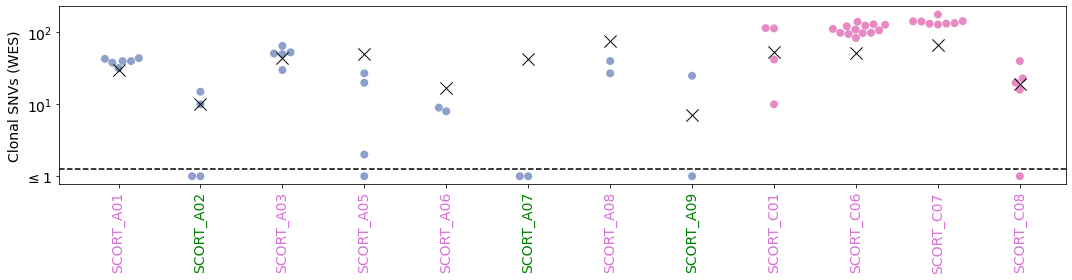

In [11]:
# EXTENDED DATA FIGURE 8b

WGS_cutoff = 27 + 36
WES_cutoff = WGS_cutoff * 0.02

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.swarmplot(x=SCORT_clonal["patient"], y=np.log10(np.maximum(1,SCORT_clonal["final_clonal"])), hue=SCORT_clonal["stage"], hue_order=["none", "alsonone", "Adenoma", "Carcinoma"], palette="Set2", legend=None, ax=ax, size=8)
sns.scatterplot(x=multiregion_lesions.index, y=np.log10(np.maximum(1, shared_counts_MRS)), marker="x", s=150, color="k", zorder=100)
ax.axhline(y=np.log10(WES_cutoff), color="k", linestyle="dashed")
plt.xticks(rotation=90, fontsize=14)

for xtick in ax.get_xticklabels():
    if counted.loc[xtick._text]["is_poly"]:
        xtick.set_color(poly_color)
    else:
        xtick.set_color(mono_color)

plt.yticks(ticks = [0, 1, 2], labels = ["$\leq 1$", "$10^{1}$", "$10^{2}$"], fontsize=14)
plt.ylabel("Clonal SNVs (WES)", fontsize=14)
#plt.yscale("log")
plt.xlabel("")
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8b_sporadic_Cross_clonalmuts.pdf")
plt.show()

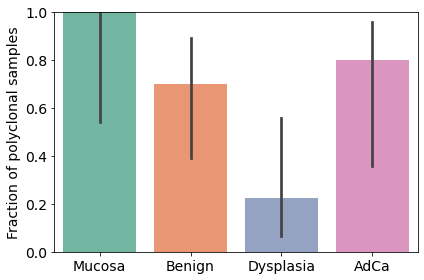

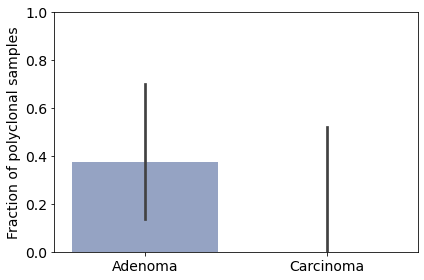

In [12]:
# EXTENDED DATA FIGURE 8c-d

def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def compute_errorbars(binom_data):
    return compute_binomial_bayes_CI(np.sum(binom_data.astype("boolean")), np.sum(~binom_data.astype("boolean")))

counted_labels = PUTH_clonal.groupby("lesion").min()
counted_labels = dict(zip(counted_labels.index, counted_labels["stage"]))

counted = PUTH_clonal.groupby("lesion").mean()
counted["is_poly"] = counted["is_poly"] >= 0.5
counted["stage"] = [counted_labels[x] for x in counted.index] 

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.barplot(x=counted["stage"], y=counted["is_poly"], order=["Mucosa", "Benign", "Dysplasia", "AdCa"], palette="Set2", errorbar=compute_errorbars)
plt.ylabel("Fraction of polyclonal samples", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8c_FAP_Li_polyclonal.pdf")
plt.show()

counted_labels = SCORT_clonal.groupby("patient").min()
counted_labels = dict(zip(counted_labels.index, counted_labels["stage"]))

counted = SCORT_clonal.groupby("patient").mean()
counted["is_poly"] = counted["is_poly"] >= 0.5
counted["stage"] = [counted_labels[x] for x in counted.index] 

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.barplot(x=counted["stage"], y=counted["is_poly"], hue_order=["Adenoma", "Carcinoma"], palette=set2_colors[2:], errorbar=compute_errorbars)
plt.ylabel("Fraction of polyclonal samples", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8d_sporadic_Cross_polyclonal.pdf")
plt.show()